## Problem 2: Superimposed Sine Waves

**Goal**: Recover the unknown heat source $f(x,t)$.

**Given Solution ($u_{true}$)**:
$$u(x,t) = [\sin(\pi x) - 0.5\sin(2\pi x)] \sin(\pi t)$$

**Derived Source ($f_{true}$)**:
$$f = u_t - u_{xx}$$
$$f = \pi \cos(\pi t) [\sin(\pi x) - 0.5\sin(2\pi x)] + \pi^2 \sin(\pi t) [\sin(\pi x) - 2\sin(2\pi x)]$$

**Boundary Conditions**: 
$u(0,t) = 0, u(1,t) = 0$ (Dirichlet zero boundaries).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters and Grid Setup (Problem 2) ---

L = 1.0
T = 1.0 
alpha = 1.0 

nx = 50     
nt = 10000 

dx = L / (nx - 1)
dt = T / (nt - 1)

x = np.linspace(0, L, nx)
t = np.linspace(0, T, nt)
X, T_mesh = np.meshgrid(x, t)

# Stability check
cfl_number = alpha * dt / (dx**2)
print(f"CFL Number: {cfl_number:.4f}")

CFL Number: 0.2401


## Ground Truth Data Generation (Method of Manufactured Solutions)

We use **Problem 1** to generate the synthetic "observed" data.

* **True Temperature ($u_{true}$)**: $u(x,t) = \sin(2\pi x) + \sin(\pi t)$
* **True Source ($f_{true}$)**: Derived analytically from the heat equation.

In [2]:
# --- 2. Ground Truth Generation (Problem 2) ---

# u(x,t) = [sin(pi*x) - 0.5*sin(2*pi*x)] * sin(pi*t)
u_true = (np.sin(np.pi * X) - 0.5 * np.sin(2 * np.pi * X)) * np.sin(np.pi * T_mesh)

# f calculations based on u_t - u_xx
# Term 1 (from u_t): pi * cos(pi*t) * [spatial_part]
term1 = np.pi * np.cos(np.pi * T_mesh) * (np.sin(np.pi * X) - 0.5 * np.sin(2 * np.pi * X))

# Term 2 (from -u_xx): pi^2 * sin(pi*t) * [sin(pi*x) - 2*sin(2*pi*x)]
term2 = (np.pi**2) * np.sin(np.pi * T_mesh) * (np.sin(np.pi * X) - 2 * np.sin(2 * np.pi * X))

f_true = term1 + term2

# Assume perfect observation
u_obs = u_true.copy()

## Solvers (Forward & Adjoint)

We implement two solvers using the Finite Difference Method:

1.  **Forward Solver**: Solves $u_t - u_{xx} = f$ forward in time to get $u$.
2.  **Adjoint Solver**: Solves $-p_t - p_{xx} = (u - u_{obs})$ backward in time to get the adjoint variable $p$.

The gradient of the cost function with respect to $f$ is simply the adjoint variable $p$.

In [3]:
# --- 3. Finite Difference Solvers ---

def solve_forward(f_input):
    """
    Solves the heat equation u_t - u_xx = f forward in time.
    Dynamic BCs/ICs: Reads from the global u_obs/u_true structure to apply correct boundaries.
    """
    u = np.zeros((nt, nx))
    
    # --- Universal Initial & Boundary Conditions ---
    # Instead of hardcoding specific formulas (like sin(pi*t)), we simply copy
    # the values from the ground truth (u_true) or observation (u_obs).
    # This makes the solver compatible with Problem 1, Problem 2, and Problem 3 automatically.
    
    # 1. Initial Condition (t=0)
    u[0, :] = u_true[0, :]  
    
    # 2. Boundary Conditions (x=0, x=L)
    u[:, 0] = u_true[:, 0]   # Left Boundary
    u[:, -1] = u_true[:, -1] # Right Boundary
    
    # Explicit Euler Time Stepping
    for n in range(0, nt - 1):
        # Compute Laplacian (u_xx) using central difference
        u_xx = (u[n, 2:] - 2*u[n, 1:-1] + u[n, 0:-2]) / (dx**2)
        
        # Update interior points
        # u_new = u_old + dt * (alpha * u_xx + f)
        u[n+1, 1:-1] = u[n, 1:-1] + dt * (alpha * u_xx + f_input[n, 1:-1])
        
    return u


def solve_adjoint(u_current, u_target):
    """
    Solves the adjoint equation -p_t - p_xx = (u - u_target) backward in time.
    """
    p = np.zeros((nt, nx))
    
    # Terminal Condition: p(T) = 0 (Implicitly zero initialization)
    
    # Backward Time Stepping
    for n in range(nt - 2, -1, -1):
        # p_xx calculation (Central Difference) based on p at n+1
        p_xx = (p[n+1, 2:] - 2*p[n+1, 1:-1] + p[n+1, 0:-2]) / (dx**2)
        
        # Source term for adjoint equation is the residual (u - u_obs)
        residual = u_current[n+1, 1:-1] - u_target[n+1, 1:-1]
        
        # Update interior points (Backward Euler-ish)
        # -p_t = p_xx + residual => (p[n] - p[n+1])/dt = p_xx + residual
        # p[n] = p[n+1] + dt * (p_xx + residual)
        p[n, 1:-1] = p[n+1, 1:-1] + dt * (alpha * p_xx + residual)
        
    return p

## Optimization Loop

We iterate to minimize the objective function.

**Configuration**:
* **Learning Rate**: Step size for gradient descent.
* **Non-negativity Constraint**: If `True`, we enforce $f \ge 0$ at every step (Projected Gradient Descent).
    * *Note*: For Problem 1, the true $f$ contains negative values. Enabling this constraint will prevent convergence to the exact true solution, but is often required in real-world physical problems (e.g., heating only).

In [4]:
# --- 4A. Optimization Loop ---

# Settings
LEARNING_RATE = 50.0
EPOCHS = 500
ENABLE_NON_NEGATIVITY = False  # Set to True to test Projected Gradient Descent

# Initialization
f_guess = np.zeros((nt, nx))
loss_history = []

print(f"Starting optimization with Non-negativity Constraint: {ENABLE_NON_NEGATIVITY}")

for epoch in range(EPOCHS + 1):
    # A. Forward Pass
    u_pred = solve_forward(f_guess)
    
    # B. Compute Loss (L2 Norm)
    # Integral approx: sum * dx * dt * 0.5
    loss = 0.5 * np.sum((u_pred - u_obs)**2) * dx * dt
    loss_history.append(loss)
    
    # C. Backward Pass (Adjoint)
    p = solve_adjoint(u_pred, u_obs)
    
    # D. Gradient Descent Step
    # Gradient of J w.r.t f is p
    gradient = p
    f_guess = f_guess - LEARNING_RATE * gradient
    
    # E. Projection (Optional Non-negativity Constraint)
    if ENABLE_NON_NEGATIVITY:
        f_guess[f_guess < 0] = 0
        
    # Logging
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.6e}")

Starting optimization with Non-negativity Constraint: False
Epoch 0: Loss = 1.562500e-01
Epoch 50: Loss = 1.214927e-03
Epoch 100: Loss = 4.800312e-05
Epoch 150: Loss = 2.335039e-06
Epoch 200: Loss = 3.944974e-07
Epoch 250: Loss = 2.314063e-07
Epoch 300: Loss = 1.727169e-07
Epoch 350: Loss = 1.362790e-07
Epoch 400: Loss = 1.111300e-07
Epoch 450: Loss = 9.287504e-08
Epoch 500: Loss = 7.912670e-08


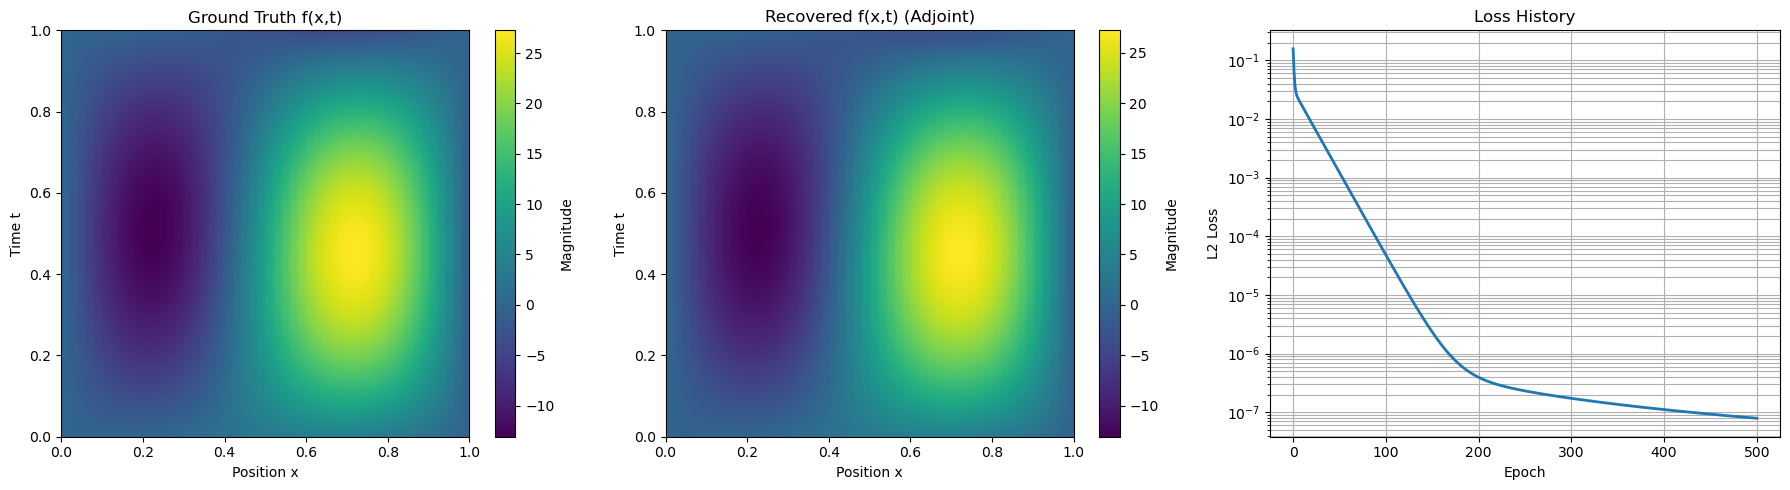

In [5]:
# --- 5A. Visualization ---

plt.figure(figsize=(18, 5))

# Plot 1: True Source Term
plt.subplot(1, 3, 1)
plt.title("Ground Truth f(x,t)")
plt.imshow(f_true, aspect='auto', extent=[0, L, 0, T], origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Position x')
plt.ylabel('Time t')

# Plot 2: Recovered Source Term
plt.subplot(1, 3, 2)
title_str = "Recovered f(x,t) (Adjoint)"
if ENABLE_NON_NEGATIVITY:
    title_str += "\n(w/ Non-negativity Constraint)"
plt.title(title_str)
plt.imshow(f_guess, aspect='auto', extent=[0, L, 0, T], origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Position x')
plt.ylabel('Time t')

# Plot 3: Loss Convergence
plt.subplot(1, 3, 3)
plt.title("Loss History")
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.yscale('log')
plt.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

In [6]:
# --- 4B. Optimization Loop ---

# Settings
LEARNING_RATE = 50.0
EPOCHS = 500
ENABLE_NON_NEGATIVITY = True  # Set to True to test Projected Gradient Descent

# Initialization
f_guess = np.zeros((nt, nx))
loss_history = []

print(f"Starting optimization with Non-negativity Constraint: {ENABLE_NON_NEGATIVITY}")

for epoch in range(EPOCHS + 1):
    # A. Forward Pass
    u_pred = solve_forward(f_guess)
    
    # B. Compute Loss (L2 Norm)
    # Integral approx: sum * dx * dt * 0.5
    loss = 0.5 * np.sum((u_pred - u_obs)**2) * dx * dt
    loss_history.append(loss)
    
    # C. Backward Pass (Adjoint)
    p = solve_adjoint(u_pred, u_obs)
    
    # D. Gradient Descent Step
    # Gradient of J w.r.t f is p
    gradient = p
    f_guess = f_guess - LEARNING_RATE * gradient
    
    # E. Projection (Optional Non-negativity Constraint)
    if ENABLE_NON_NEGATIVITY:
        f_guess[f_guess < 0] = 0
        
    # Logging
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.6e}")

Starting optimization with Non-negativity Constraint: True
Epoch 0: Loss = 1.562500e-01
Epoch 50: Loss = 6.783083e-03
Epoch 100: Loss = 5.442428e-03
Epoch 150: Loss = 5.071974e-03
Epoch 200: Loss = 4.921556e-03
Epoch 250: Loss = 4.847374e-03
Epoch 300: Loss = 4.805712e-03
Epoch 350: Loss = 4.779855e-03
Epoch 400: Loss = 4.762436e-03
Epoch 450: Loss = 4.749873e-03
Epoch 500: Loss = 4.740288e-03


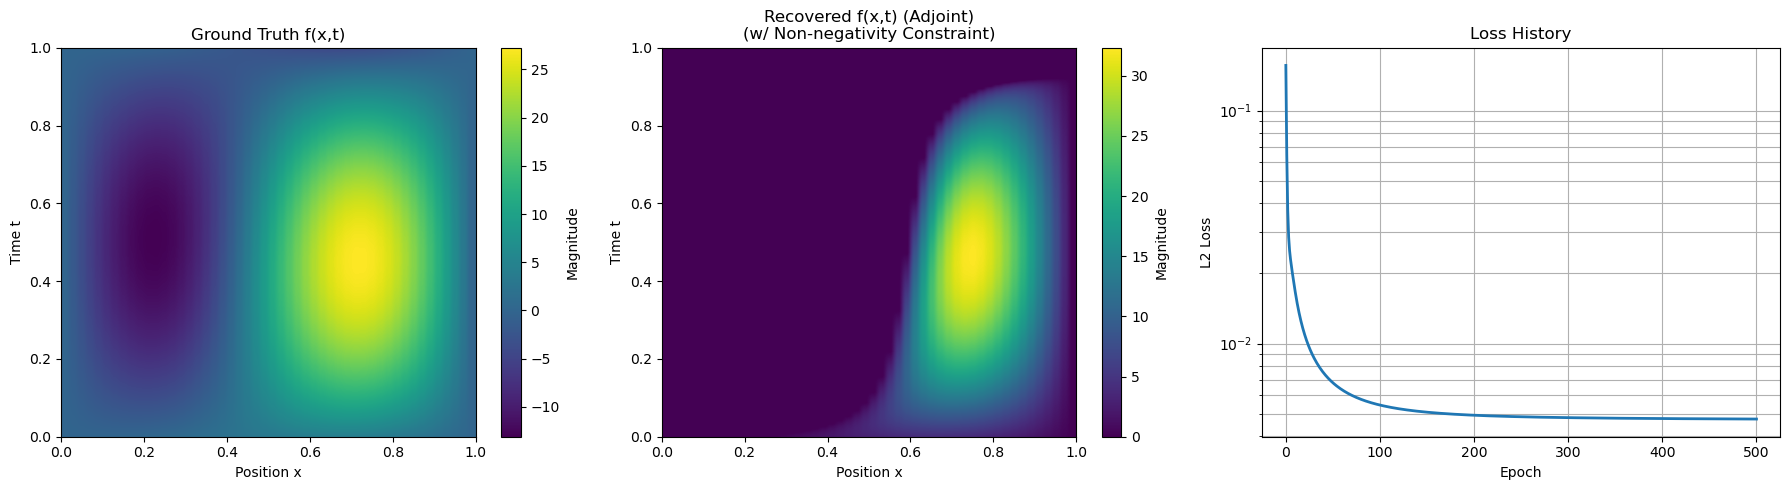

In [7]:
# --- 5B. Visualization ---

plt.figure(figsize=(18, 5))

# Plot 1: True Source Term
plt.subplot(1, 3, 1)
plt.title("Ground Truth f(x,t)")
plt.imshow(f_true, aspect='auto', extent=[0, L, 0, T], origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Position x')
plt.ylabel('Time t')

# Plot 2: Recovered Source Term
plt.subplot(1, 3, 2)
title_str = "Recovered f(x,t) (Adjoint)"
if ENABLE_NON_NEGATIVITY:
    title_str += "\n(w/ Non-negativity Constraint)"
plt.title(title_str)
plt.imshow(f_guess, aspect='auto', extent=[0, L, 0, T], origin='lower', cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Position x')
plt.ylabel('Time t')

# Plot 3: Loss Convergence
plt.subplot(1, 3, 3)
plt.title("Loss History")
plt.plot(loss_history, linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.yscale('log')
plt.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()